# Herramientas y Zona de Prueba para el MoDem LoRa

## Comprobación del correcto funcionamiento del MoDem

Para poder comprobar que la implementación en código funciona correctamente, a continuación se desarrolla una función que consistirá en:
- Generar todos los símbolos posibles para el Spreading Factor dado ($2^{SF}$ símbolos), muestras por chip y ancho de banda.
- Demodularlos sin ruido añadido
- Comparar de que para cada símbolo modulado, se lo pueda demodular correctamente

Además, se graficarán los resultados para poder visualizar mejor los resultados de la prueba.

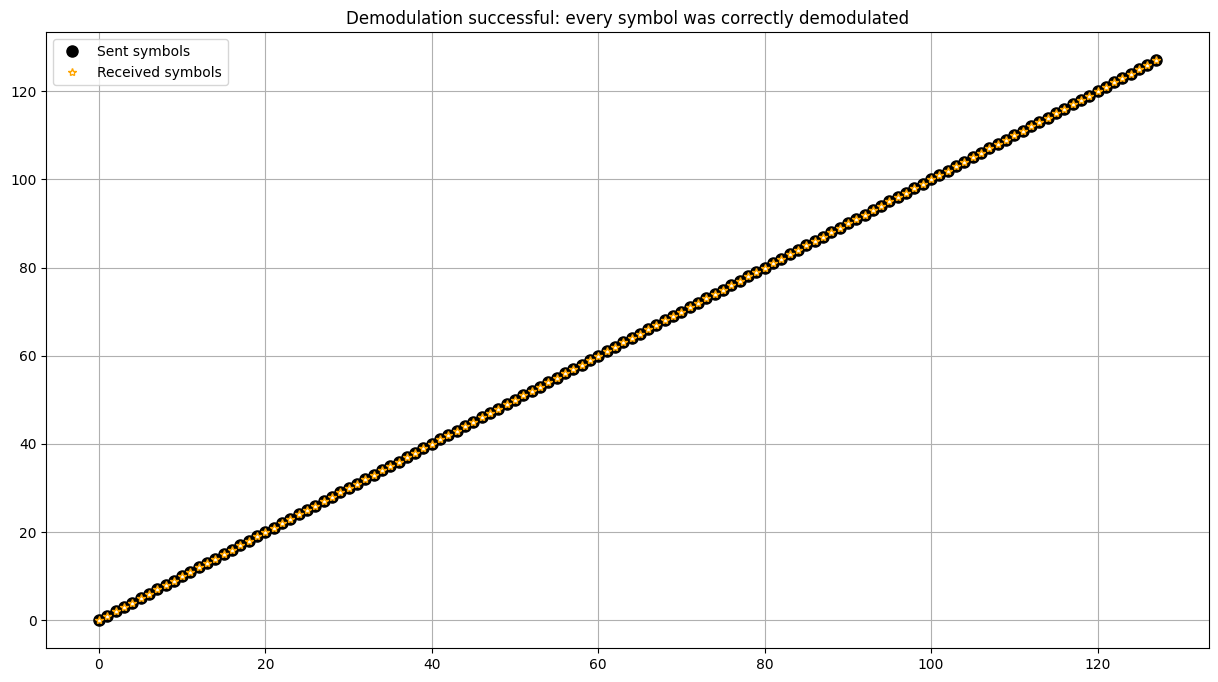

In [1]:
from lora_modem import LoraModulator, LoraDemodulator
import numpy as np
import matplotlib.pyplot as plt
def test_and_plot_all_symbols(spreading_factor, bandwidth, samples_per_chip):
    modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
    demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
    symbols_to_send= [i for i in range(2**spreading_factor)]
    signal = modulator.modulate_symbols(symbols_to_send)[2]
    received_symbols = demodulator.demodulate_symbols(signal)

    
    if symbols_to_send == received_symbols:
        plt.title('Demodulation successful: every symbol was correctly demodulated')
    else:
        plt.title('Error in demodulation')

    plt.plot(symbols_to_send,'o', label='Sent symbols', markersize=8, color = 'black')
    plt.plot(received_symbols, '*', label='Received symbols', markersize=6, color = 'white', markeredgecolor='orange')
    plt.legend()
    
    return symbols_to_send, received_symbols

plt.figure(figsize=(15, 8))
sent_symbols, received_symbols = test_and_plot_all_symbols(7, 500e3, 100)
plt.grid()
plt.show()


## Generación de Ruido Blanco Gaussiano

Para poder generar AWGN y que dependa de un SNR parametrizado, podemos aprovecharnos de que para la fórmula:

$SNR = \frac{P_S}{P_N}$

Ya conoceríamos el valor del $SNR$ por lo que deberíamos calcular:

$P_N = \frac{P_S}{SNR}$

Esto nos permite conocer la potencia del ruido, que no es más que la varianza que tendrá la función de distribución normal asociada al mismo.

Por lo tanto, una vez conocida la varianza y sabiendo que la media siempre será el valor de la muestra, se puede computar el ruido para toda la señal:

$r(t)= w(t) + \sim N(0,\sigma)$

In [2]:
def signal_power(signal):
    # Calculate the signal power
    P = np.mean(np.abs(signal)**2)
    return P

def generate_awgn(SNR, w):
    # Check if SNR is given in dB, DB, or db and convert if necessary
    if isinstance(SNR, str) and SNR.lower().endswith('db'):
        SNR_linear = 10 ** (float(SNR[:-2]) / 10)
    else:
        SNR_linear = float(SNR)
    
    signal_len = len(w)

    # Determine the noise power (variance)
    variance = signal_power(w) / SNR_linear
    std_dev = np.sqrt(variance)
    # Generate noise
    noise = np.random.normal(0, std_dev, signal_len) + 1j * np.random.normal(0, std_dev, signal_len)
    
    # Add noise to the signal
    noisy_signal = w + noise
    
    return noisy_signal, noise, variance

## Generación de las curvas de rendimiento: SER x SNR



Este código simula la relación entre la Tasa de Error de Símbolo (SER) y la Relación Señal a Ruido (SNR) en un sistema LoRa para un spreading factor (SF) dado. El objetivo es evaluar cómo la SNR afecta la probabilidad de error en la transmisión de símbolos.

 La función `generate_SER_SNR_ratio_binary(sf)` realiza esta simulación generando símbolos aleatorios, modulándolos y añadiendo ruido blanco gaussiano (AWGN), configurado para un rango dado de SNR. Luego, el símbolo con ruido se demodula y se verifica si se produjo un error en la transmisión. La SER se calcula como la proporción de errores sobre un millón de simulaciones para cada valor de SNR, que se define en un rango ajustado según el SF. Los resultados se almacenan en un archivo binario .npy $^1$, facilitando su análisis posterior. Para ejecutar la simulación, basta con llamar a la función especificando el SF deseado.
 
 
 $^{1}$ Se cambió el nombre del archivo que se generaría al ejecutar la función para no sobreescribir los ya pre-computados, debido a que se puede tardar varias horas hasta completar la generación de la curva de SER.

In [3]:
def generate_all_symbols(sf):
    mod = LoraModulator(sf, 125e3, 1)
    symbol_signals = []
    for i in range(2**sf):
        symbol_signals.append(mod.modulate_symbols([i])[2])
    return symbol_signals


def generate_SER_SNR_ratio_binary(sf, sims=1000000):
    # Set up SNR range
    snr_range = np.arange(-30 + 12 - sf, 2, 1)
    # Initialize MoDem
    
    demod = LoraDemodulator(sf, 125e3, 1)
    symbol_signals = generate_all_symbols(sf)
    # Initialize storage arrays
    SNR_values = []
    SER_values = []

    # Loop over all SNR values
    for snr in snr_range:
        print(f'Processing SER for SNR = {snr} dB')
        errors = 0
        
        for i in range(sims):
            # Generate a random message
            message = np.random.randint(0, 2**sf)
            # Modulate the message
            signal = symbol_signals[message]
            # Generate AWGN
            noisy_signal = generate_awgn(f'{snr}dB', signal)[0]
            # Demodulate the signal
            demodulated_message = demod.demodulate_symbol(noisy_signal)
            # Calculate the number of errors
            if demodulated_message != message:
                errors += 1
        
        # Calculate SER for this SNR
        SER = errors / sims
        SNR_values.append(snr)
        SER_values.append(SER)
        print(f'SER for SNR = {snr} dB is {SER}')
    
    # Convert lists to numpy arrays
    SNR_values = np.array(SNR_values)
    SER_values = np.array(SER_values)

    # Save to a binary .npy file
    np.save(f'SERxSNR/SER_SNR_ratio_sf{sf}_example.npy', np.vstack((SNR_values, SER_values)))

    print("SER-SNR Metrics successfully generated and saved in binary format for a Spreading Factor of", sf)



## Visualización de las curvas de SER x SNR

Aquí se encuentra el código para visualizar el rendimiento de la modulación para distintos niveles de SNR. Para ello, se graficarán los valores de los ejes con escala logarítmica en el eje Y. Además, se superpondrán las curvas de cada spreading factor (SF) con el objeto de apreciar las diferencias de rendimiento entre cada configuración.

In [4]:
def plot_SER_SNR_from_binary(filename, sf):
    # Load the binary file
    data = np.load(filename)
    SNR_values = data[0, :]
    SER_values = data[1, :]
    # Plot the data
    plt.plot(SNR_values, SER_values, marker='o', linestyle='-', label=f'SF {sf}')
    plt.xlim([SNR_values.min(), SNR_values.max()])
    plt.yscale('log')  # Logarithmic scale for SER
    plt.xlabel('SNR (dB)')
    plt.ylabel('SER (log scale)')
    plt.title(f'LoRa MoDem: SER vs. SNR')
    plt.grid(True)

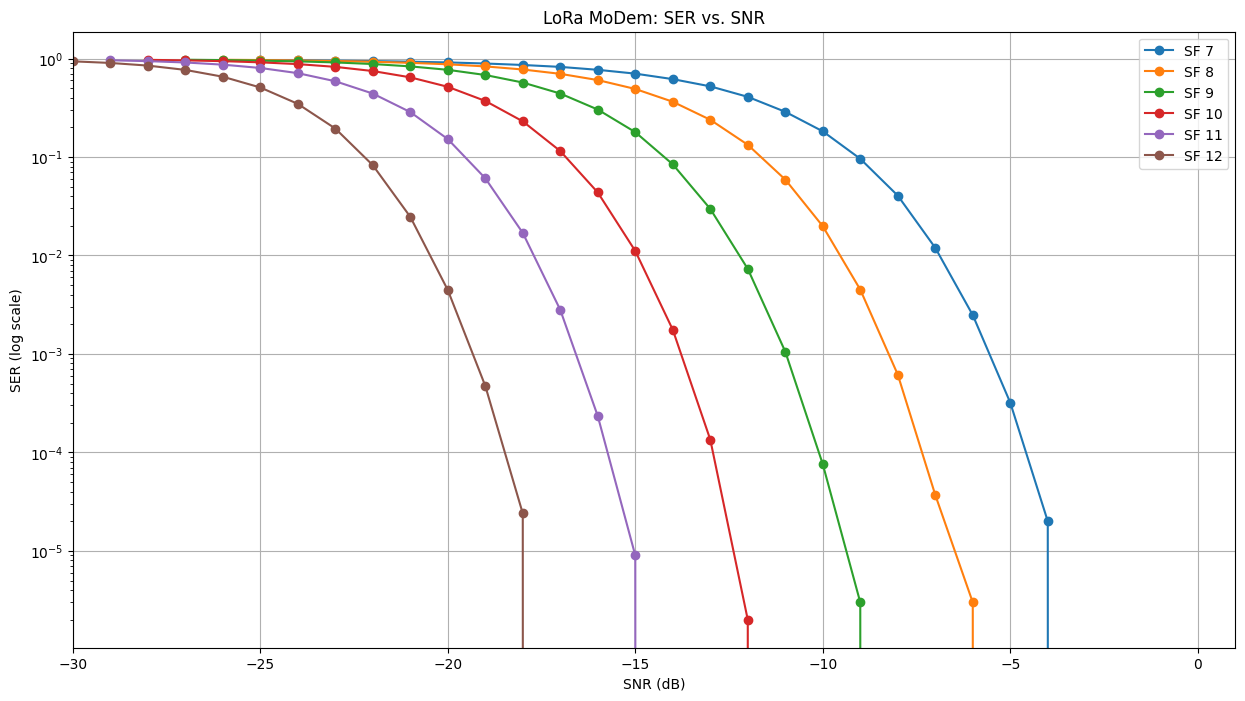

In [5]:
plt.figure(figsize=(15, 8))
plot_SER_SNR_from_binary(f'SERxSNR/SER_SNR_ratio_sf7.npy', 7)
plot_SER_SNR_from_binary(f'SERxSNR/SER_SNR_ratio_sf8.npy', 8)
plot_SER_SNR_from_binary(f'SERxSNR/SER_SNR_ratio_sf9.npy', 9)
plot_SER_SNR_from_binary(f'SERxSNR/SER_SNR_ratio_sf10.npy', 10)
plot_SER_SNR_from_binary(f'SERxSNR/SER_SNR_ratio_sf11.npy', 11)
plot_SER_SNR_from_binary(f'SERxSNR/SER_SNR_ratio_sf12.npy', 12)
plt.legend()
plt.show()